In [2]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

seed=42

In [3]:
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

2023-01-27 05:51:10.831046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 05:51:10.832118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 05:51:10.832792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-27 05:51:10.835266: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
df = pd.read_csv('/kaggle/input/amerix-sa-nlp-deep-cleaned-data/sentiment_adv_preprocessed_data.csv', index_col=0)

In [5]:
df.head()

,tweet_created_at,text_clean,Sentiment
0,2022-05-20 16:01:49+00:00,actor amp cookbook author recently joined the ...,1
1,2022-08-23 15:26:31+00:00,sprinkled a little kindness to brighten someon...,1
2,2021-10-15 17:23:25+00:00,the body is not stupid it has an efficient hom...,1
3,2022-11-19 16:26:01+00:00,food for the thought masculinitysaturday,2
4,2022-12-12 08:59:22+00:00,why though,2


In [6]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Positive', 'Neutral']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [7]:
ros = RandomOverSampler()

train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));

ros_df = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [8]:
ros_df['Sentiment'].value_counts()

1    129038
2    129038
0    129038
Name: Sentiment, dtype: int64

In [9]:
X = ros_df['text_clean'].values
y = ros_df['Sentiment'].values

In [10]:
x_, x_test, y_, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x_, y_, test_size=0.2, stratify=y_, random_state=42)

In [12]:
y_train_c = y_train.copy()
y_valid_c = y_val.copy()
y_test_c = y_test.copy()

In [13]:
encoder = preprocessing.OneHotEncoder()

y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = encoder.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [14]:
print(f"Training Data: {x_train.shape[0]}\nValidation Data: {x_val.shape[0]}\nTesting Data: {x_test.shape[0]}" )

Training Data: 216783
Validation Data: 54196
Testing Data: 116135


In [15]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [16]:
token_lens = []

for txt in x_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)

max_length

92

In [17]:
MAX_LEN = 128

In [18]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    
    input_ids = []
    attention_masks = []
    
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [19]:
train_input_ids, train_attention_masks = tokenize_roberta(x_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(x_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(x_test, MAX_LEN)

In [20]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [21]:
def create_model(roberta_model, max_len=MAX_LEN):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = roberta_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    
    return model

In [22]:
rbt_model = create_model(roberta_model, MAX_LEN)
rbt_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 3)            2307        tf_roberta_model[0][1]       

In [23]:
print("--> Checking for physical Tensorflow devices")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

--> Checking for physical Tensorflow devices
: /physical_device:CPU:0
: /physical_device:GPU:0


In [24]:
print("--> Checking for physical Tensorflow devices")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

--> Checking for physical Tensorflow devices
: /physical_device:CPU:0
: /physical_device:GPU:0


In [26]:
roberta_train_tune = rbt_model.fit([train_input_ids,train_attention_masks], 
                      y_train, 
                      validation_data=([val_input_ids,val_attention_masks], y_val), epochs=4, batch_size=30)

2023-01-27 06:00:37.443390: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4
7227/7227 [==============================] - 3635s 501ms/step - loss: 0.3060 - categorical_accuracy: 0.8914 - val_loss: 0.1949 - val_categorical_accuracy: 0.9360
Epoch 2/4
7227/7227 [==============================] - 3617s 501ms/step - loss: 0.1710 - categorical_accuracy: 0.9450 - val_loss: 0.1578 - val_categorical_accuracy: 0.9485
Epoch 3/4
7227/7227 [==============================] - 3616s 500ms/step - loss: 0.1287 - categorical_accuracy: 0.9586 - val_loss: 0.1389 - val_categorical_accuracy: 0.9571
Epoch 4/4
7227/7227 [==============================] - 3616s 500ms/step - loss: 0.0994 - categorical_accuracy: 0.9678 - val_loss: 0.1238 - val_categorical_accuracy: 0.9634


In [27]:
roberta_prediction = rbt_model.predict([test_input_ids,test_attention_masks])

In [28]:
roberta_y_predictions =  np.zeros_like(roberta_prediction)
roberta_y_predictions[np.arange(len(roberta_y_predictions)), roberta_prediction.argmax(1)] = 1

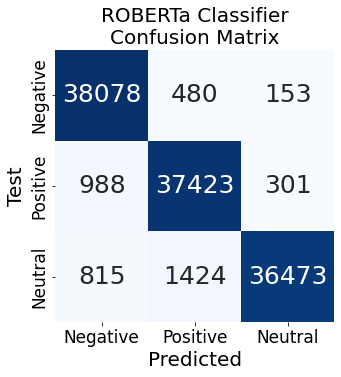

In [30]:
conf_matrix(y_test.argmax(1), roberta_y_predictions.argmax(1),'ROBERTa Classifier\nConfusion Matrix')

In [31]:

print('\tROBERTa Classification Report\n\n',classification_report(y_test,roberta_y_predictions, 
                                                                    target_names=['Negative', 'Positive', 'Neutral']))

	ROBERTa Classification Report

               precision    recall  f1-score   support

    Negative       0.95      0.98      0.97     38711
    Positive       0.95      0.97      0.96     38712
     Neutral       0.99      0.94      0.96     38712

   micro avg       0.96      0.96      0.96    116135
   macro avg       0.96      0.96      0.96    116135
weighted avg       0.96      0.96      0.96    116135
 samples avg       0.96      0.96      0.96    116135

